# Evaluation the performance of our algorithms

### Load the data

In [3]:
import os
import sys
import pickle
import networkx as nx
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
from pprint import pprint

# Add the project root directory to the system path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from StructuredRag.evaluation import graph_scoring
from StructuredRag.processing import graph_construction

/Users/lukasalemu/Downloads/ls/envs/dissertation_rag/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [4]:
# Select the runs you want to load
for experiment in sorted(os.listdir('../results')):
    print('Experiment:', experiment)
    for run in sorted(os.listdir('../results/' + experiment)):
        print("     || Run:", run)

Experiment: v0
     || Run: 2024-05-10
     || Run: 2024-05-14
     || Run: 2024-05-25
     || Run: 2024-05-27
     || Run: 2024-06-14
     || Run: 2024-07-18
     || Run: 2024-08-03
Experiment: v1
     || Run: 2024-05-10
     || Run: 2024-05-14
Experiment: v3
     || Run: 2024-05-10
     || Run: 2024-05-14
Experiment: v4
     || Run: 2024-05-10
     || Run: 2024-05-14
Experiment: v5
     || Run: 2024-05-14


In [12]:
run_path = 'v0/2024-08-03'
# run_path = 'v1/2024-05-14'
# run_path = 'v3/2024-05-14'
# run_path = 'v4/2024-05-14'
# run_path = 'v5/2024-05-14'

run_list = {
    'v0': 'v0/2024-08-03',
    'v1': 'v1/2024-05-14',
    'v3': 'v3/2024-05-14',
    'v4': 'v4/2024-05-14',
    'v5': 'v5/2024-05-14',
}

In [6]:
data = {}
# Read the data for the specified experiment
for item in os.listdir('../results/' + run_path):
    print('Loading item:', item.split('.')[0])
    
    with open('../results/' + run_path + '/' + item, 'rb') as f:
        data[item.split('.')[0]] = pickle.load(f)

Loading item: embedded_index
Loading item: notes
Loading item: edge_thresh
Loading item: adj_matrix


In [13]:
test_df = pd.DataFrame(index=[0], columns=run_list.keys())

weights = []
scaled_weights_list = []
for run_name, run_path in run_list.items():
    
    data = {}
    # Read the data for the specified experiment
    for item in os.listdir('../results/' + run_path):
        print('Loading item:', item.split('.')[0])
        
        with open('../results/' + run_path + '/' + item, 'rb') as f:
            data[item.split('.')[0]] = pickle.load(f)
    
    weights_list = []
    for node in data['adj_matrix']:
        for node2 in data['adj_matrix'][node]:
            weights_list.append(data['adj_matrix'][node][node2]['weight'])
    
    weights.append(weights_list)
    
    scaler = sklearn.preprocessing.RobustScaler()
    scaled_weights = scaler.fit_transform(
            np.array(weights_list).reshape(-1, 1)
        ).flatten()
    
    # scaled_weights = sklearn.preprocessing.normalize(np.array(weights_list).reshape(1, -1)).flatten()
    scaled_weights_list.append(scaled_weights)


Loading item: embedded_index
Loading item: notes
Loading item: edge_thresh
Loading item: adj_matrix
Loading item: embedded_index
Loading item: notes
Loading item: adj_matrix
Loading item: embedded_index
Loading item: notes
Loading item: adj_matrix
Loading item: embedded_index
Loading item: notes
Loading item: adj_matrix
Loading item: embedded_index
Loading item: notes
Loading item: adj_matrix


In [14]:
# Fit the scaled lists into a dataframe by padding ones which are shorted with nans
test_df = pd.DataFrame(scaled_weights_list, index=run_list)
test_df = test_df.transpose()

test_df

,v0,v1,v3,v4,v5
0,0.114509,0.976232,0.000000,-1.375483,0.383334
1,-0.250716,0.951662,-0.691244,-1.371227,0.383334
2,-0.353216,0.962211,0.000000,-1.380325,0.383334
3,0.312009,0.963413,0.000000,-1.369582,0.383334
4,0.000110,0.956870,0.000000,-1.382084,0.383334
...,...,...,...,...,...
23634,NaN,NaN,0.000000,NaN,NaN
23635,NaN,NaN,0.000000,NaN,NaN
23636,NaN,NaN,0.000000,NaN,NaN
23637,NaN,NaN,0.000000,NaN,NaN


### Distribution of edge weights


Text(0.5, 0.5, 'TEMPORARY')

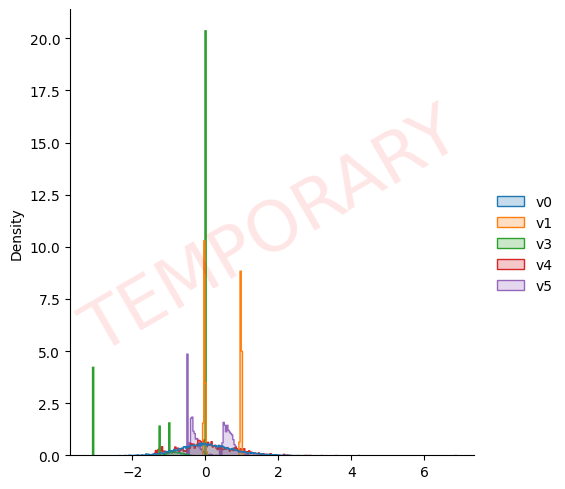

In [15]:
g = sns.displot(test_df, element='step', stat='density', common_norm=False)

# new_labels = ['V0', 'V4', 'V5']
# for text, new_label in zip(g._legend.get_texts(), new_labels):
#     text.set_text(new_label)

# Add a watermark to the chart that says TEMPORARY
plt.text(0.5, 0.5, 'TEMPORARY', fontsize=50, color='red', alpha=0.1,
         ha='center', va='center', rotation=30, transform=g.ax.transAxes)


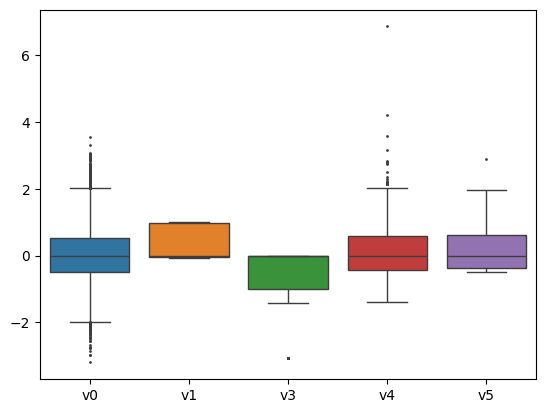

In [16]:
# Box plots of the edge weights
g = sns.boxplot(
    data = test_df,
    showfliers=True,
    flierprops={"marker": ".", "markersize": 2},
    # showcaps=False,
    # fill=False, 
    # width=.5,  
    # linewidth=.75,
)


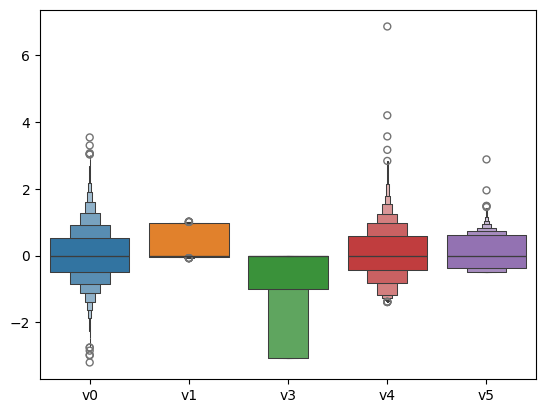

In [19]:
# Box plots of the edge weights
g = sns.boxenplot(
    data = test_df,
)

Text(0.5, 0.5, 'TEMPORARY')

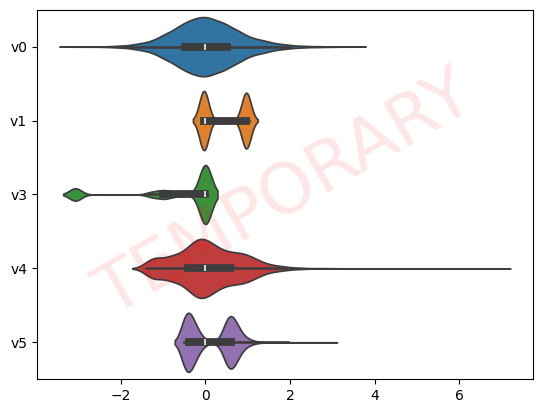

In [17]:
g = sns.violinplot(
    data = test_df,
    orient='h',
    saturation=0.75,
)

plt.text(0.5, 0.5, 'TEMPORARY', fontsize=50, color='red', alpha=0.1,
         ha='center', va='center', rotation=30, transform=g.transAxes)


### Evaluate our selected data

In [25]:
# Construct the graph
graph = graph_construction.construct_graph_from_adj_dict(
    adj_dict=data['adj_matrix'],
    edge_thresh=data['edge_thresh'],
    embedded_index=data['embedded_index'],
)
graph_eval = None

graph_scoring.quick_stats(graph)

Adding edges to graph: 100%|██████████| 440/440 [00:00<00:00, 157156.92it/s]


{'number_of_nodes': 441,
 'number_of_edges': 2156,
 'average_degree': 9.777777777777779,
 'density': 0.022222222222222223,
 'clustering_coefficient': 0.22944938484815633}

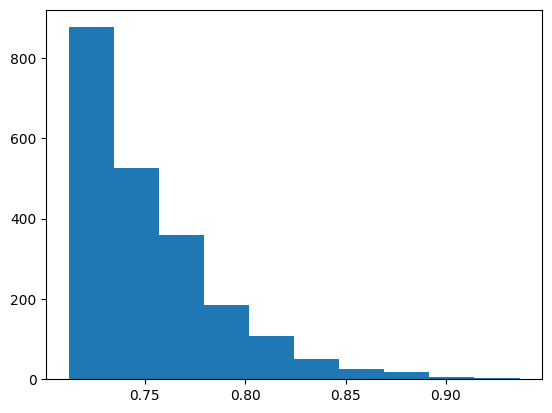

In [23]:
# Plot the distribution of edge_weights:
weights = []

for edge in list(graph.edges(data=True)):
    weights.append(edge[2]['weight'])

plt.hist(weights)
plt.show()


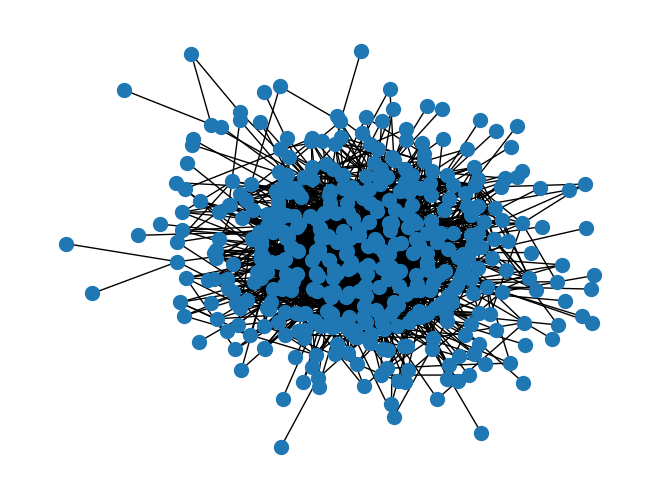

In [31]:
# Visualise the generated graph
pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, pos, node_size=100)

In [32]:
# Evaluate the graph
graph_eval = graph_scoring.evaluate_graph(graph)

# View the results without the communities (as its long)
{k: v for k, v in graph_eval.items() if k != 'communities'}

KeyboardInterrupt: 

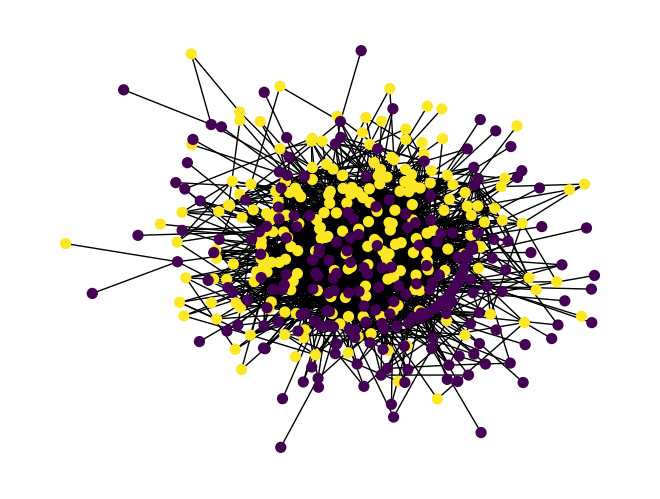

In [33]:
# Draw the graph, but use the node_id to identify which of the two headline document elements is referenced within the node
unique_docs = []
for doc in data['embedded_index']:
    unique_docs.append(doc.metadata['file_name'])
    
unique_docs = set(unique_docs)

# Create a list colors which is the same length as the unique docs
cmap = mpl.colormaps['viridis']
list_of_colors = cmap(np.linspace(0, 1, len(unique_docs)))

color_dict = {}
for idx, doc_name in enumerate(unique_docs):
    color_dict[doc_name] = list_of_colors[idx]

colors = []
for n in graph.nodes:
    for doc in data['embedded_index']:
        if doc.id_ == n:
            colors.append(color_dict[doc.metadata['file_name']])
            # if doc.metadata['file_name'] == unique_docs[0]:
            #     colors.append('red')
            # else:
            #     colors.append('blue')
                
pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, pos, node_size=50, node_color=colors)

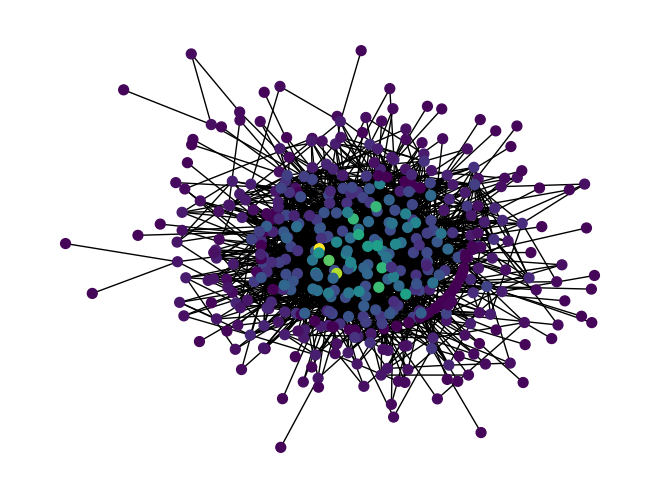

In [12]:
# Step 1: Compute centrality measures
centrality = nx.degree_centrality(graph)

# Color the nodes along a gradient of centrality
color_map = []
for node in graph.nodes:
    color_map.append(centrality[node])
    
# Step 2: Normalize the centrality values
min_centrality = min(color_map)
max_centrality = max(color_map)
color_map = [(centrality - min_centrality) / (max_centrality - min_centrality) for centrality in color_map]

# Step 3: Convert the color map to a list of RGB values using viridis colormap
cmap = mpl.colormaps['viridis']
color_map = [cmap(color) for color in color_map]

# Step 4: Draw the graph with the color map
pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, pos, node_size=50, node_color=color_map)

The modularity of this method is: 0.6461848743155089


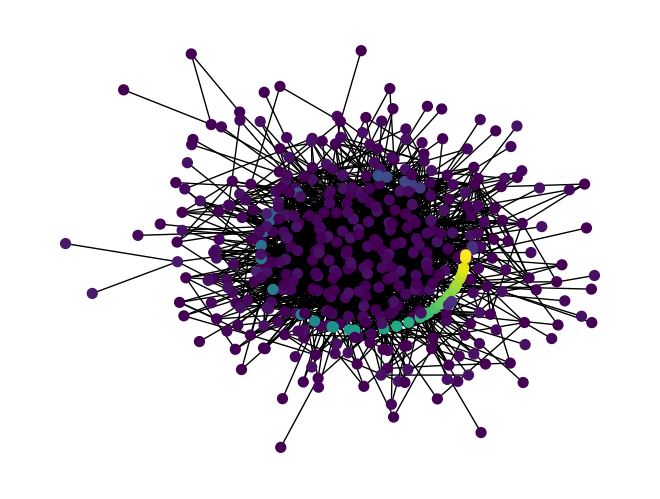

In [16]:
# if not graph_eval:
graph_eval = {**graph_scoring.community_detection(graph)}

try:
    graph_eval['communities']

    community_node_list = graph_eval['communities']

    # Split viridis into n colors
    cmap = mpl.colormaps['viridis']
    colors = cmap(np.linspace(0, 1, len(community_node_list)))

    # Create a dictionary that maps each community to a color
    community_color_dict = {community: color for community, color in zip(community_node_list, colors)}

    node_colors = []

    for node in graph.nodes:
        # Find which community the node belongs to
        for community, color in community_color_dict.items():
            if node in community:
                node_colors.append(color)

    # Draw the graph with the communities colored
    pos = nx.kamada_kawai_layout(graph)
    nx.draw(graph, pos, node_size=50, node_color=node_colors)

    # Print the modularity of the partition
    print("The modularity of this method is:", graph_eval['community_modularity'])

    # # Do some evaluation for each of the communities detected.
    # for com_nodes in community_node_list:
    #     subgraph = graph.subgraph(com_nodes)
    #     subgraph_eval = graph_scoring.simple_stats(subgraph)
    #     # subgraph_eval2 = graph_scoring.attribute_stats(subgraph)
        
    #     pprint.pprint(subgraph_eval)
    #     # pprint.pprint(subgraph_eval2)
        
    #     print("-------------------")
except KeyError:
    print('Skipping')

In [52]:
list(graph.edges(data=True))[100]

('96c3eee3-e1e2-4c7d-93f2-aea752e9c34a',
 'd56a04a6-9310-432e-a84c-44af2c48dbcb',
 {'weight': 0.7186387777328491})

In [20]:

list(graph.nodes)[0]

test = nx.single_source_dijkstra(
    G=graph, source=list(graph.nodes)[0], weight="weight"
)

# Print last 10 elements of the test
list(test[0].items())[-10:][-1][0]

'34259494-a223-4dee-89b1-7036628852a1'

In [29]:
graph.nodes(data=True)['34259494-a223-4dee-89b1-7036628852a1']

{'page_label': '43',
 'file_name': '/Users/lukasalemu/Documents/00. Bank of England/00. Degree/Dissertation/structured-rag/data/01_raw/monetary policy report february 2024.pdf',
 'Description': 'The 2024 MPR from the Bank of England for the month of February. Contains the forecasts, projections, etc.',
 'Type': 'MPR',
 'Date': '2024-02-04 00:00:00',
 'Authors': 'Bank of England',
 'Topics': 'Inflation, GDP, Labour Market, Forecasts',
 'Brands': 'MPR',
 'Academic Research Cited?': 'No',
 'Divisions': 'Monetary Analysis',
 'MPC Round': 'Feb 2024',
 'Forecast Round': 'Feb 2024',
 'Tags': 'nan',
 'Related Notes': 'nan',
 'links': "['https://www.gov.uk/government/publications/monetary-policy-remit-autumn-statement-2023', 'http://www.bankofengland.co.uk/monetary-policy-report/2024/february-2024', 'http://www.bankofengland.co.uk/monetary-policy-report/2024/february-2024', 'https://www.bankofengland.co.uk/monetary-policy-report/2024/february-2024#chapter-10', 'https://www.federalreserve.gov/ne

In [30]:
graph.nodes(data=True)[list(graph.nodes)[0]]

{'page_label': 'Cover',
 'file_name': '/Users/lukasalemu/Documents/00. Bank of England/00. Degree/Dissertation/structured-rag/data/01_raw/MPR November 2023.pdf',
 'Description': 'Our quarterly Monetary Policy Report sets out the economic analysis and inflation projections that the Monetary Policy Committee uses to make its interest rate decisions.',
 'Type': 'MPR',
 'Date': '2023-02-11 00:00:00',
 'Authors': 'Bank of England',
 'Topics': 'Inflation, GDP, Labour Market, Forecasts',
 'Brands': 'MPR',
 'Academic Research Cited?': 'No',
 'Divisions': 'Monetary Analysis',
 'MPC Round': 'Nov 2023',
 'Forecast Round': 'Nov 2023',
 'Tags': 'nan',
 'Related Notes': 'nan',
 'links': "['https://www.bankofengland.co.uk/monetary-policy-report/2023/november-2023#chapter-10', 'https://www.bankofengland.co.uk/monetary-policy-report/2023/november-2023#chapter-10', 'https://www.federalreserve.gov/newsevents/speech/files/yellen20170926a.pdf', 'https://www.bankofengland.co.uk/speech/2018/andy-haldane-advi